# Baseline Metrics Evaluation

## Framework/ Library Installation

In [ ]:
# Installs unsloth and other dependencies optimized for colab
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
!pip install --upgrade transformers accelerate bitsandbytes

  Cloning https://github.com/unslothai/unsloth.git to /tmp/pip-install-86g66316/unsloth_31d5b258674c474a93b90633adcc3740
  Running command git clone --filter=blob:none --quiet https://github.com/unslothai/unsloth.git /tmp/pip-install-86g66316/unsloth_31d5b258674c474a93b90633adcc3740
  Resolved https://github.com/unslothai/unsloth.git to commit 5ce83f272bd9e726b68b0a0452b8b04d32477133
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.0/129.0 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 119.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.3/124.3 kB 15.2 MB/s eta 0:00:

## Helper Functions


Evaluate the zero-shot performance of unsloth/gemma-3-1b-it-bnb-4bit
on the openai/gsm8k dataset.

This code below performs the following:
1. Imports libraries
2. Defines functions to:
    - Load the specified Unsloth Gemma model and tokenizer.
    - Load and prepare the gsm8k dataset, formatting prompts correctly.
    - Extract the final numeric answer from text using regex.
    - Run the evaluation loop: generate answers, extract numbers, compare.
3. Executes the main evaluation process:
    - Loads model and data.
    - Runs evaluation (optionally on a subset).
    - Prints accuracy results.
    - Saves detailed results to a CSV file.
    - Generates a simple plot of the accuracy.

In [ ]:
import unsloth
from unsloth import FastLanguageModel

import re
import torch
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset
from tqdm.notebook import tqdm
import warnings, math

In [ ]:
# Load the model and tokenizer
def load_model():
    """
    Load the Gemma 3 1B model with Unsloth optimizations.
    Returns the model and tokenizer as a tuple.
    """
    model_name = "unsloth/gemma-3-1b-it-bnb-4bit"

    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name,
        load_in_4bit=True,
        device_map="auto", #selects gpu if available
    )
    FastLanguageModel.for_inference(model)

    # sets padding token to eos_token if not set already
    if tokenizer.pad_token is None:
      tokenizer.padding_side="left"
      tokenizer.pad_token = tokenizer.eos_token
      model.config.pad_token_id = tokenizer.eos_token_id

    elif tokenizer.padding_side != "left":
      print("padding side is kept to left for batch generation")
      tokenizer.padding_side="left"

    return model, tokenizer

In [ ]:
def prepare_dataset(split: str = "test"):
    """
    Loads the gsm8k dataset and prepares it for evaluation.

    Formats questions into prompts suitable for the Gemma instruction-tuned model
    and extracts the final numeric gold answer.

    Args:
        split (str): The dataset split to load ('test' or 'train').
                     Defaults to 'test'.

    Returns:
        list: A list of dictionaries, where each dictionary contains:
              'prompt': The formatted input prompt for the model.
              'gold_answer_numeric': The extracted final numeric answer as a string.
              'original_question': The original question text.
              'original_answer': The full original answer text with reasoning.
    """
    print(f"Loading and preparing gsm8k dataset (split: {split})...")
    gsm8k = load_dataset("openai/gsm8k", "main")
    dataset_split = gsm8k[split]

    formatted_data = []
    for example in tqdm(dataset_split, desc=f"Formatting {split} data"):
        question = example["question"].strip()
        answer_full = example["answer"].strip()

        # Extract the final numeric answer after "####"
        try:
            # Splits by "####" and takes the last part using strip function
            gold_answer_numeric = re.split(r"####\s*", answer_full)[-1].strip()
        except Exception as e:
            print(f"Warning: Could not parse gold answer for question: {question[:50]}... Error: {e}")
            gold_answer_numeric = None

        # Formatting the prompt using Gemma's instruction format
        # Reference: https://huggingface.co/google/gemma-1.1-2b-it#chat-template
        prompt = f"<start_of_turn>user\nSolve the following math problem step-by-step:\n{question}<end_of_turn>\n<start_of_turn>model\n"

        formatted_data.append({
            "prompt": prompt,
            "gold_answer_numeric": gold_answer_numeric,
            "original_question": question,
            "original_answer": answer_full
        })
    print(f"Dataset preparation complete. {len(formatted_data)} examples formatted.")
    return formatted_data

In [ ]:
@torch.no_grad() # stops gardient computation since we are performing only inference
def evaluate_zero_shot(model, tokenizer, dataset: list,batch_size:int=8, max_new_tokens: int = 150, num_samples: int | None = None):
    """
    Evaluates the model's zero-shot performance on the prepared dataset.

    Args:
        model: The loaded language model (Unsloth optimized).
        tokenizer: The tokenizer associated with the model.
        batch_size(int): number of examples to process on GPU
        dataset (list): The list of formatted data dictionaries from prepare_gsm8k_dataset.
        max_new_tokens (int): Maximum number of tokens to generate for the answer.
        num_samples (int | None): If set, evaluate only the first 'num_samples'.
                                  If None, evaluate the entire dataset.

    Returns:
        dict: A dictionary containing evaluation metrics and detailed results:
              'accuracy': The exact match accuracy (float).
              'correct_count': Number of correctly answered questions (int).
              'total_count': Total number of questions evaluated (int).
              'results': A list of dictionaries with details for each sample.
    """
    if num_samples is not None and num_samples > 0:
        print(f"Evaluating on the first {num_samples} samples.")
        dataset = dataset[:num_samples]
    else:
        print(f"Evaluating on the full dataset ({len(dataset)} samples).")

    correct_count = 0
    results_list = []
    total_count=len(dataset)

    # set pad token to eos token if not set
    gen_pad_token_id = tokenizer.pad_token_id if tokenizer.pad_token_id is not None else tokenizer.eos_token_id

    # number of batches
    num_batches = math.ceil(total_count / batch_size)

    # Looping through dataset in batches
    for i in tqdm(range(num_batches), desc=f"Evaluating Batches (Size {batch_size})"):
        start_index = i * batch_size
        end_index = min((i + 1) * batch_size, total_count)
        batch_data = dataset[start_index:end_index]

        # prompts and gold answers for the batch
        batch_prompts = [example["prompt"] for example in batch_data]
        batch_gold_numeric = [example["gold_answer_numeric"] for example in batch_data]

        # Tokenizes the batch of prompts
        inputs = tokenizer(
            batch_prompts,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=1024
        ).to(model.device)

        # generating outputs for the entire batch
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            temperature=0.0,
            do_sample=False,
            pad_token_id=gen_pad_token_id
        )

        # Decode generated text for the batch
        # We need to decode starting after the input sequence for each item
        input_lengths = inputs.input_ids.shape[1] # Length of padded input
        # Decode each sequence in the batch individually
        generated_texts = tokenizer.batch_decode(outputs[:, input_lengths:], skip_special_tokens=True)

        # Handling results for each item in the batch
        for j in range(len(batch_data)):
            original_example = batch_data[j]
            generated_text = generated_texts[j]
            gold_numeric = batch_gold_numeric[j]

            # Extracting the final number from the generated text
            generated_numeric = extract_final_number(generated_text)

            # Comparing extracted numbers for exact match
            is_correct = False
            if gold_numeric is not None and generated_numeric is not None:
                try:
                    if abs(float(generated_numeric) - float(gold_numeric)) < 1e-6: # Tolerance for float comparison
                        is_correct = True
                except ValueError:
                    if generated_numeric == gold_numeric: # Fallback to string comparison
                        is_correct = True

            if is_correct:
                correct_count += 1

            # Store detailed results
            results_list.append({
                "question": original_example["original_question"],
                "prompt": original_example["prompt"], # Store the original prompt
                "full_gold_answer": original_example["original_answer"],
                "gold_numeric": gold_numeric,
                "generated_text": generated_text,
                "generated_numeric": generated_numeric,
                "is_correct": is_correct
            })

    # final accuracy computation
    accuracy = (correct_count / total_count) if total_count > 0 else 0.0

    print(f"Evaluation Complete: Correct = {correct_count}, Total = {total_count}, Accuracy = {accuracy:.4f}")

    return {
        "accuracy": accuracy,
        "correct_count": correct_count,
        "total_count": total_count,
        "results": results_list
    }

==((====))==  Unsloth 2025.4.7: Fast Gemma3 patching. Transformers: 4.51.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = None. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: Using float16 precision for gemma3 won't work! Using float32.
Loading and preparing gsm8k dataset (split: test)...


Formatting test data:   0%|          | 0/1319 [00:00<?, ?it/s]

Dataset preparation complete. 1319 examples formatted.
Evaluating on the full dataset (1319 samples).


Evaluating Batches (Size 128):   0%|          | 0/11 [00:00<?, ?it/s]

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='le

Evaluation Complete: Correct = 303, Total = 1319, Accuracy = 0.2297

--- Evaluation Summary ---
Model: unsloth/gemma-3-1b-it-bnb-4bit
Dataset: GSM8K (test split)
Batch Size: 128
Samples Evaluated: 1319
Accuracy (Exact Match): 0.2297
Correct Answers: 303
-------------------------

Detailed results saved to: unsloth_gemma-3-1b-it-bnb-4bit_gsm8k_test_zero_shot_results.csv
Accuracy plot saved to: unsloth_gemma-3-1b-it-bnb-4bit_gsm8k_test_zero_shot_accuracy.png


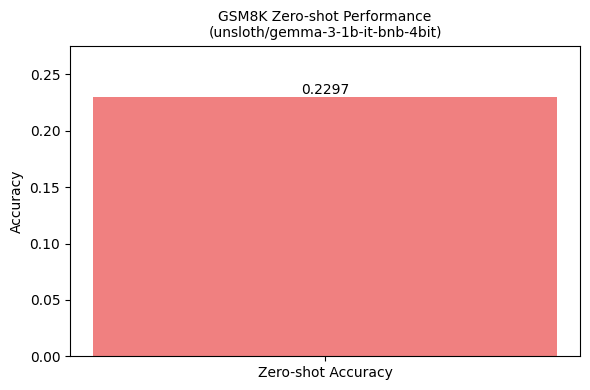

In [ ]:
def main():
    """
    Main function to orchestrate the zero-shot evaluation process.
    """
    # --- Configuration ---
    model_name = "unsloth/gemma-3-1b-it-bnb-4bit"
    dataset_split = "test"
    num_eval_samples = None # performs evaluation for the entire dataset_split
    max_generation_tokens = 200
    evaluation_batch_size=128

    output_csv_file = f"{model_name.replace('/', '_')}_gsm8k_{dataset_split}_zero_shot_results.csv"
    output_plot_file = f"{model_name.replace('/', '_')}_gsm8k_{dataset_split}_zero_shot_accuracy.png"

    # 1. Load Model
    model, tokenizer = load_model()

    # 2. Prepare Data
    evaluation_dataset = prepare_dataset(split=dataset_split)

    #3. Evaluate
    evaluation_results = evaluate_zero_shot(
        model,
        tokenizer,
        evaluation_dataset,
        max_new_tokens=max_generation_tokens,
        num_samples=num_eval_samples,
        batch_size=evaluation_batch_size,
    )

    # 4. Save Results
    print("\n--- Evaluation Summary ---")
    print(f"Model: {model_name}")
    print(f"Dataset: GSM8K ({dataset_split} split)")
    print(f"Batch Size: {evaluation_batch_size}")
    print(f"Samples Evaluated: {evaluation_results['total_count']}")
    print(f"Accuracy (Exact Match): {evaluation_results['accuracy']:.4f}")
    print(f"Correct Answers: {evaluation_results['correct_count']}")
    print("-------------------------\n")

    # Save results to CSV
    try:
        results_df = pd.DataFrame(evaluation_results['results'])
        results_df.to_csv(output_csv_file, index=False)
        print(f"Detailed results saved to: {output_csv_file}")
    except Exception as e:
        print(f"Error saving results to CSV: {e}")

    # plotting the accuracy
    try:
        plt.figure(figsize=(6, 4))
        plt.bar(['Zero-shot Accuracy'], [evaluation_results['accuracy']], color='lightcoral')
        plt.ylabel('Accuracy')
        plt.title(f'GSM8K Zero-shot Performance\n({model_name})', fontsize=10)
        plt.ylim(0, max(0.1, evaluation_results['accuracy'] * 1.2))
        plt.text(0, evaluation_results['accuracy'], f'{evaluation_results["accuracy"]:.4f}', ha='center', va='bottom')
        plt.tight_layout()
        plt.savefig(output_plot_file)
        print(f"Accuracy plot saved to: {output_plot_file}")
        plt.show()
    except Exception as e:
        print(f"Error generating plot: {e}")

if __name__ == "__main__":
    main()